<a href="https://colab.research.google.com/github/the-SQuAD-squad/QA/blob/huggingface-regression/QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers
from tokenizers import BertWordPieceTokenizer

!pip install transformers
import transformers
from transformers import AutoTokenizer
pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
# Huggingface bert and associated tokenizer
#pretrained_model_str = "google/electra-small-discriminator"#
#bert_hf_layer = transformers.TFElectraModel.from_pretrained(
#    pretrained_model_str, output_attentions=True)

pretrained_model_str = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)

bert_hf_layer = transformers.TFRobertaModel.from_pretrained(
    pretrained_model_str, output_attentions=True)


     |████████████████████████████████| 3.2MB 5.7MB/s 
     |████████████████████████████████| 1.8MB 5.9MB/s 
     |████████████████████████████████| 890kB 64.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=f4b03fb2d0d2feae6f67b2fb0416eeab1eb3de6cfad41d44e4f9758ef464217b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


# Dataset creation

In [2]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-02-24 16:46:34--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M  76.1MB/s    in 0.4s    

2021-02-24 16:46:35 (76.1 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [3]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_bert = df_original.set_index('id')
df_bert = df_bert.drop(unwanted_id)
df_bert.head()

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"(381, 420)",a Marian place of prayer and reflection
5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary rep

In [4]:
def preprocess_bert(text):
    #preprocesed_text = [" ".join(str(line).split()) for line in text]
    tokenized_text = tokenizer(text, return_offsets_mapping=True)

    rows_out  = [{'input_ids': tokenized_text.input_ids[i],
                  'offsets': tokenized_text.offset_mapping[i]} for i in range(len(text))]

    return rows_out

preprocess_bert(["hi mum", "hi dad"])


[{'input_ids': [0, 3592, 8562, 2],
  'offsets': [(0, 0), (0, 2), (3, 6), (0, 0)]},
 {'input_ids': [0, 3592, 4252, 2],
  'offsets': [(0, 0), (0, 2), (3, 6), (0, 0)]}]

In [ ]:
tokenizer("hi mum", "hi dad",return_offsets_mapping=True)

{'input_ids': [0, 3592, 8562, 2, 2, 3592, 4252, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 2), (3, 6), (0, 0), (0, 0), (0, 2), (3, 6), (0, 0)]}

In [5]:
#@title BERT preprocessing { form-width: "25%" }
from tqdm import tqdm

def preprocess_bert(text):
    tokenized_text = tokenizer(list(text), return_offsets_mapping=True)

    rows_out  = [{'input_ids': tokenized_text.input_ids[i],
                  'offsets': tokenized_text.offset_mapping[i]} for i in range(len(text))]

    return rows_out

def labeling(df):
    skip = []
    ans_token_start = []
    ans_token_end = []
    input_word_ids = []
    input_type_ids = []
    input_mask = []
    context_token_to_char = []

    for id in tqdm(df.index):
        answer = " ".join(str(df.loc[id]['answer_text']).split())
        tokenized_context = df.loc[id]['passage']
        tokenized_question = df.loc[id]['question']

        # mark all the character indexes in context that are also in answer     
        is_char_in_ans = [0] * len(df_bert.loc[id]['passage'])
        for idx in range(*df.loc[id]['answer_idx']):
            is_char_in_ans[idx] = 1
        ans_token_idx = []
        # find all the tokens that are in the answers
        for idx, (start, end) in enumerate(tokenized_context["offsets"]): #start is index of the first character of the word, end is the index of the last character of the word
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)
        if len(ans_token_idx) == 0:
            skip.append(id)
            continue
        # create inputs as usual
        input_ids = tokenized_context['input_ids'] + tokenized_question['input_ids'][1:] #removing CLS from the beginning of the question 
        token_type_ids = [0] * len(tokenized_context['input_ids']) + [1] * len(tokenized_question['input_ids'][1:])
        attention_mask = [1] * len(input_ids)
        padding_length = max_seq_length - len(input_ids)
        
        # add padding if necessary
        if padding_length > 0:
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:
            skip.append(id)
            continue
        input_word_ids.append(np.array(input_ids))
        input_type_ids.append(np.array(token_type_ids))
        input_mask.append(np.array(attention_mask))
        context_token_to_char.append(np.array(tokenized_context["offsets"]))
        ans_token_start.append(ans_token_idx[0])
        ans_token_end.append(ans_token_idx[-1])

    df = df.drop(skip)
    df['input_word_ids'] = input_word_ids
    df['input_type_ids'] = input_type_ids
    df['input_mask'] = input_mask
    df['context_token_to_char'] = context_token_to_char
    df['ans_token_start'] = ans_token_start
    df['ans_token_end'] = ans_token_end

    return df    

df_bert_preprocessed = df_bert.copy()
# pre-process passage and question text
print("Preprocessing passage...")
df_bert_preprocessed['passage'] = preprocess_bert(df_bert['passage'])
print("Preprocessing question...")
df_bert_preprocessed['question'] = preprocess_bert(df_bert['question'])
print("Building attention masks...")
df_bert_preprocessed = labeling(df_bert_preprocessed)


Preprocessing passage...


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


Preprocessing question...


  0%|          | 108/87364 [00:00<01:21, 1072.12it/s]

Building attention masks...


100%|██████████| 87364/87364 [01:02<00:00, 1399.78it/s]


In [ ]:
#df_bert_preprocessed = pd._pickle("df_bert_preprocessed_fast.pkl")
  

#Skip preprocessing

In [ ]:
#@title load/store { form-width: "25%" }
import pickle
load = True #@param {type: "boolean"}

if load:
    !gcloud config set project feisty-mechanic-221914
    !gsutil cp gs://squad_squad/df_bert_preprocessed.pkl.zip ./df_bert_preprocessed.pkl.zip
    !unzip -o ./df_bert_preprocessed.pkl.zip
    df_bert_preprocessed = pd.read_pickle("./df_bert_preprocessed.pkl")
else:
    df_bert_preprocessed.to_pickle("df_bert_preprocessed.pkl")
    !zip df_bert_preprocessed.pkl.zip df_bert_preprocessed.pkl

    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project feisty-mechanic-221914
    !gsutil cp ./df_bert_preprocessed.pkl.zip gs://squad_squad/df_bert_preprocessed.pkl.zip

!nvidia-smi

#Regression TODO

- fix train data  
- fixed val data  
- fix mae loss +1  
- check model  
- fix metrics  

#Model

In [27]:
#@title split { form-width: "25%" }

split_value = 0.1 #@param {type:"number"} 
val_dim = int(len(df_bert_preprocessed['title'].unique()) * split_value)
val_titles = np.random.choice(df_bert_preprocessed['title'].unique(), size=val_dim, replace=False)

df_bert_val = df_bert_preprocessed[df_bert_preprocessed['title'].isin(val_titles)]
df_bert_train = df_bert_preprocessed[~(df_bert_preprocessed['title'].isin(val_titles))]

x_train = [np.stack(df_bert_train["input_word_ids"]),
           np.stack(df_bert_train["input_mask"]),
           np.stack(df_bert_train["input_type_ids"])]

y_train= [np.stack(df_bert_train["ans_token_start"]),
          np.stack(df_bert_train["ans_token_end"])]

x_val = [np.stack(df_bert_val["input_word_ids"]),
          np.stack(df_bert_val["input_mask"]),
          np.stack(df_bert_val["input_type_ids"])]

y_val = [np.stack(df_bert_val["ans_token_start"]),
         np.stack(df_bert_val["ans_token_end"])]
         
y_val_reg = [np.stack(df_bert_val["ans_token_start"]),
              np.stack(df_bert_val["ans_token_end"]) - np.stack(df_bert_val["ans_token_start"])]

(array([7.543e+03, 1.117e+03, 4.030e+02, 1.250e+02, 9.700e+01, 5.800e+01,
        2.100e+01, 1.300e+01, 4.000e+00, 2.000e+00]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <a list of 10 Patch objects>)

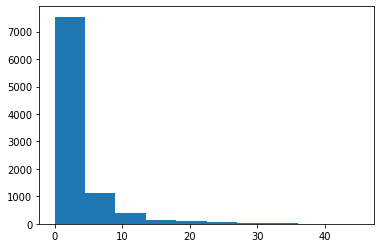

In [28]:
import matplotlib.pyplot as plt

plt.hist(y_val_reg[1])


In [30]:
#@title model definition { form-width: "25%" }

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')

#pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

#HUGGINGFACE 🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗
bert_output = bert_hf_layer(input_ids=input_word_ids, attention_mask=input_mask, 
                                token_type_ids=input_type_ids)

sequence_output = bert_output.last_hidden_state
pooler_output = bert_output.pooler_output

start_logits = layers.Dense(1, name="start_logit", use_bias=False)(sequence_output)
start_logits = layers.Flatten(name="flatten_start")(start_logits)

end_logits = layers.Dense(1, name="end_logit")(pooler_output)


start_probs = layers.Activation(keras.activations.softmax, name="softmax_start")(start_logits)
end_probs = layers.Activation(keras.activations.relu, name="relu_span")(end_logits)

model = keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                    outputs=[start_probs, end_probs],
                    name="BERT_QA")

ce = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
mae = tf.keras.losses.MeanAbsoluteError()

optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.summary(line_length=150)

Model: "BERT_QA"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_word_ids (InputLayer)                      [(None, 512)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
input_mask (InputLayer)                          [(None, 512)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
input_type_ids (InputLayer)                      [(None, 512)]               

In [32]:
#@title metrics { form-width: "25%" }

def prec(y_true, y_pred):
    sampled = tf.argmax(y_pred, axis=-1)
    return 1 - tf.math.count_nonzero(tf.squeeze(tf.cast(y_true, tf.int64)) - sampled) / tf.cast(len(sampled), tf.int64)

def dist(y_true, y_pred):
    sampled = tf.argmax(y_pred, axis=-1)
    return tf.reduce_sum(tf.abs(tf.squeeze(tf.cast(y_true, tf.int64)) - sampled)) / tf.cast(len(sampled), tf.int64)

In [ ]:
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [34]:
#@title train { form-width: "25%" }
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
batch_size = 8
epochs = 200
steps_per_epoch = 20
saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
chkpt = saveDir + '/squad_check.hdf5'

ENABLE_WANDB = False        #@param {type:"boolean"}
wandb_experiment_name = "HF_" + bert_hf_layer.name  #@param {type: "string"}
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    wandb.init(project="SQUAD", name=wandb_experiment_name)
    wandb.config.batch_size = batch_size
    wandb.config.epochs = epochs
    
es_cb = EarlyStopping(monitor='val_loss', patience=2,verbose=1, mode='auto')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [es_cb, cp_cb]

if ENABLE_WANDB:
    callbacks.append(WandbCallback(log_batch_frequency=10,
                                   save_weights_only=True))

tf.keras.backend.clear_session()

model.compile(optimizer=optimizer, loss=[ce,mae], metrics=[prec,dist])
history = model.fit(x_train, y_train, epochs=epochs,callbacks=callbacks, 
                    validation_data=(x_val,y_val_reg),batch_size=batch_size)#,
                    #steps_per_epoch = steps_per_epoch)

Epoch 1/200
 680/9730 [=>............................] - ETA: 1:21:25 - loss: 58.7122 - softmax_start_loss: 2.9629 - relu_end_loss: 55.7493 - softmax_start_prec: 0.2998 - softmax_start_dist: 28.6800 - relu_end_prec: 0.0000e+00 - relu_end_dist: 70.7019

KeyboardInterrupt: ignored

#Evaluation

In [ ]:
#@title download best weights
#!wget https://wandb.ai/veri/SQUAD/runs/1t78812w/files/model-best.h5
model.load_weights("saved_models/squad_check.hdf5")

In [38]:
import matplotlib.pyplot as plt

predictions = model.predict(x_val)
sampled_start = np.argmax(predictions[0], axis=-1)
sampled_span = predictions[1]

plt.figure(figsize=(30,30))
plt.plot(y_val_reg[0], y_val_reg[0] + y_val_reg[1], ".");
plt.plot(sampled_start, sampled_start + sampled_span,"*");

Error in callback <function flush_figures at 0x7fcf155a7290> (for post_execute):


KeyboardInterrupt: ignored

In [40]:
sampled_start = np.argmax(predictions[0], axis=-1)
sampled_span = predictions[1]

In [52]:
sampled_span.squeeze().shape

(9383,)

In [53]:
computed_end = sampled_start + sampled_span.squeeze()
computed_end.shape

(9383,)

(array([4061., 2338., 1717.,  773.,  265.,  133.,   64.,   19.,    7.,
           6.]), array([ 37.23519135,  79.535849  , 121.83650665, 164.13716431,
        206.43782196, 248.73847961, 291.03913727, 333.33979492,
        375.64045258, 417.94111023, 460.24176788]), <a list of 10 Patch objects>)

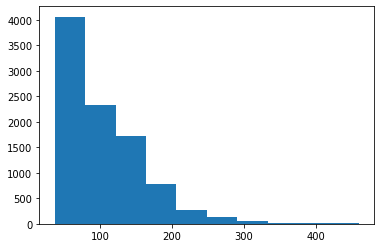

In [54]:
plt.hist(computed_end)

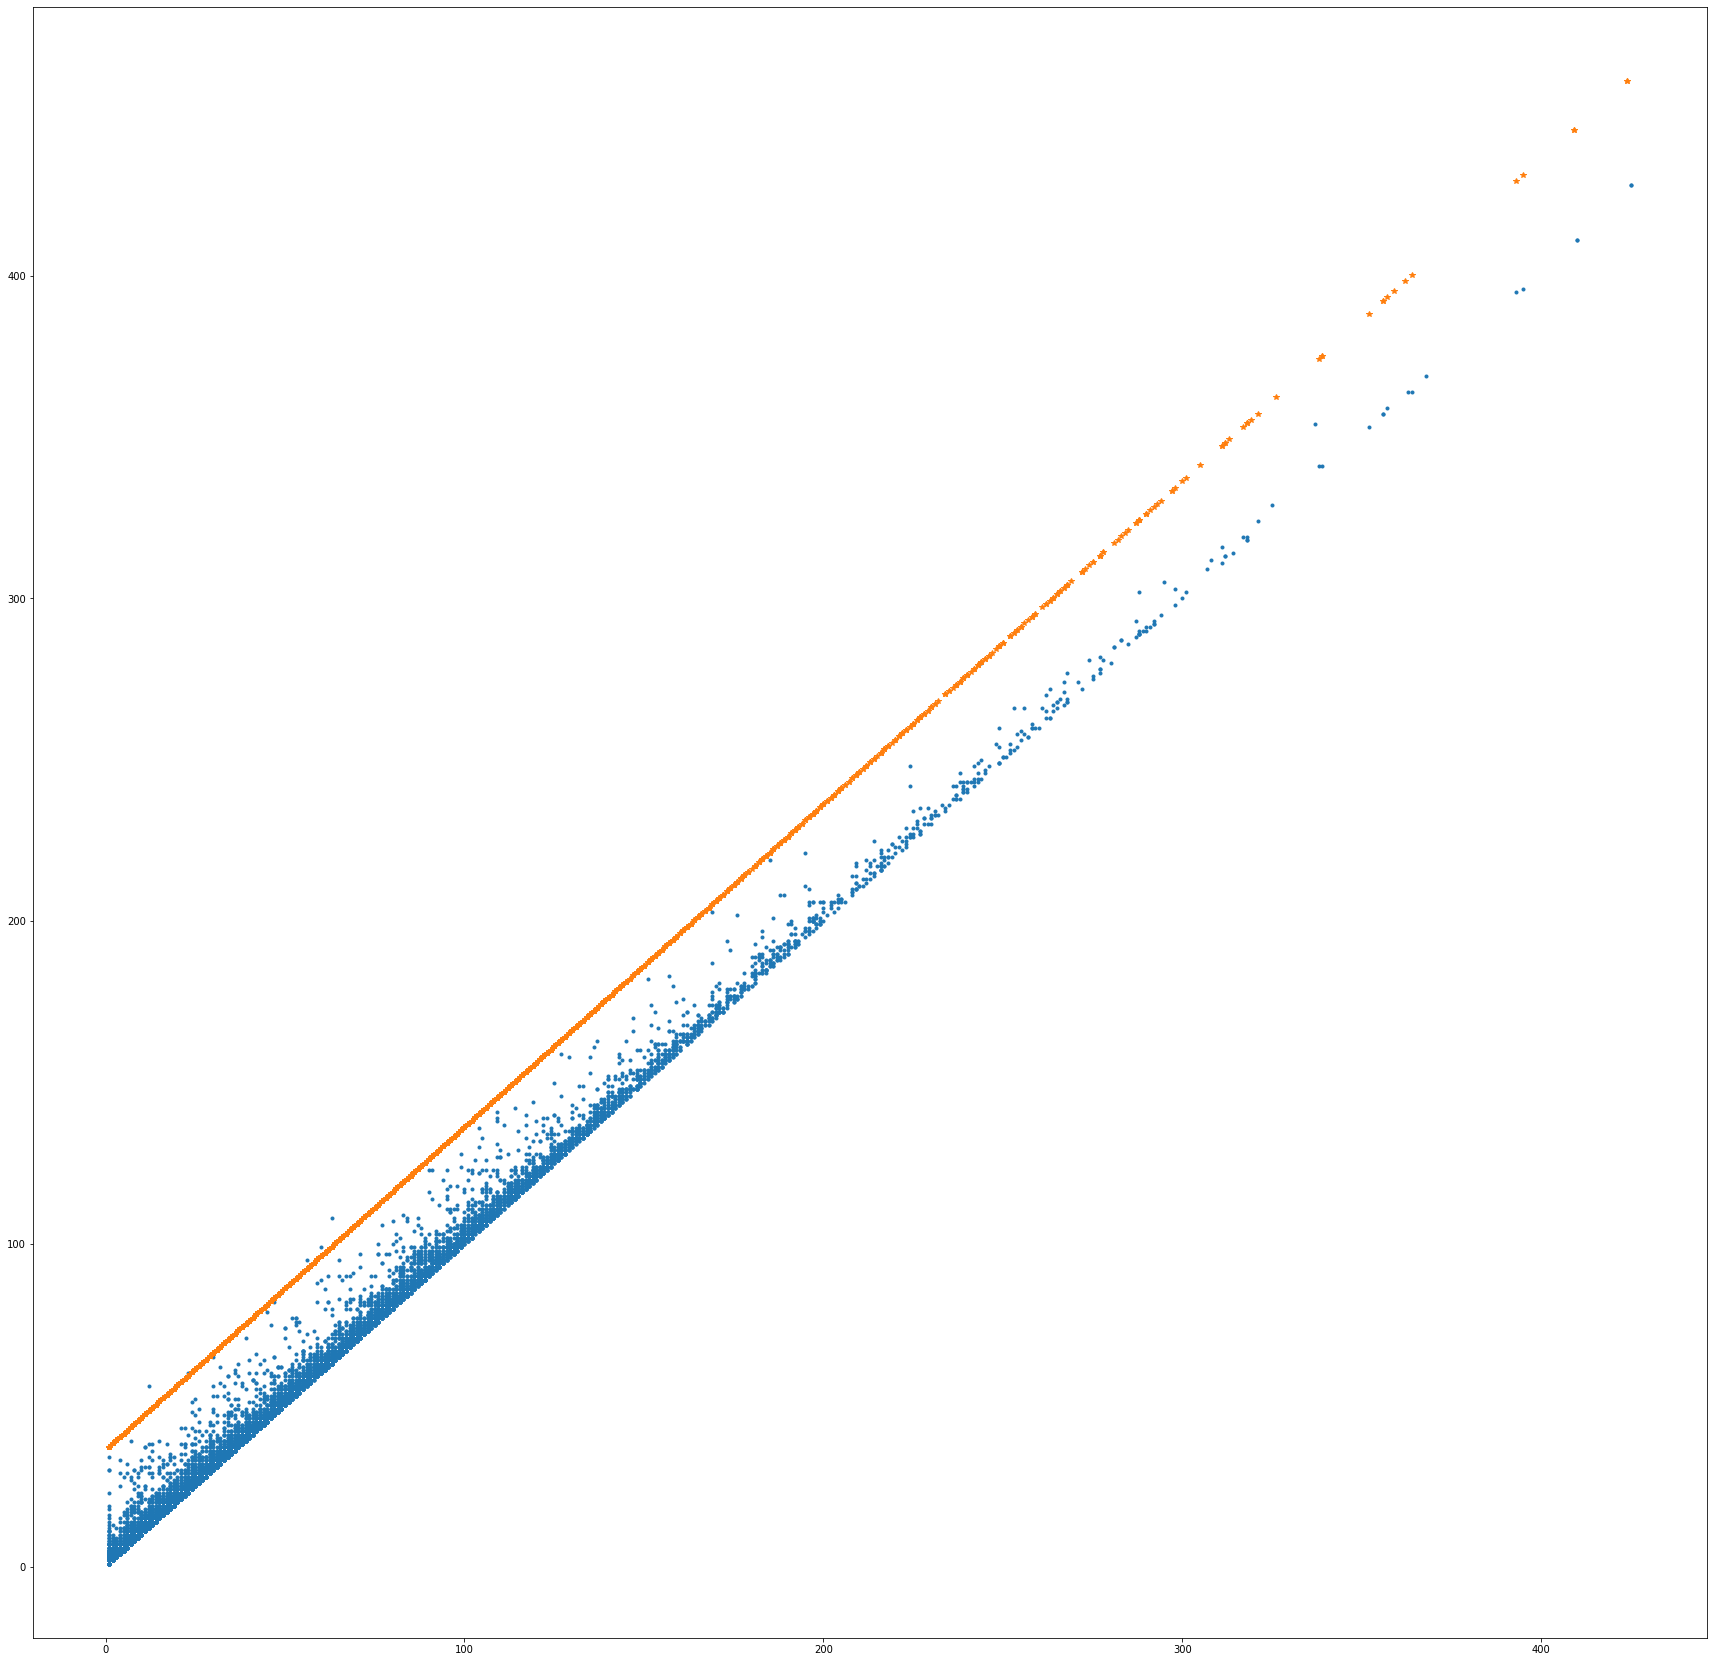

In [61]:

plt.figure(figsize=(30,30))
plt.plot(y_val_reg[0], y_val_reg[0] + y_val_reg[1], ".");
plt.plot(sampled_start, computed_end,"*");
plt.show()

In [ ]:
!gsutil cp gs://squad_squad/evaluate.py ./evaluate.py
!chmod +x ./evaluate.py

Copying gs://squad_squad/evaluate.py...
/ [1 files][ 10.3 KiB/ 10.3 KiB]                                                
Operation completed over 1 objects/10.3 KiB.                                     


In [ ]:
# preprocess dev set

!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json -O test_set.json

with open("test_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_dev = pd.DataFrame(rows)

def preprocess_bert(text):
    tokenized_text = tokenizer(list(text), return_offsets_mapping=True)

    rows_out  = [{'input_ids': tokenized_text.input_ids[i],
                  'offsets': tokenized_text.offset_mapping[i]} for i in range(len(text))]

    return rows_out

def labeling(df):
    skip = []
    ans_token_start = []
    ans_token_end = []
    input_word_ids = []
    input_type_ids = []
    input_mask = []
    context_token_to_char = []

    for id in tqdm(df.index):
        answer = " ".join(str(df.loc[id]['answer_text']).split())
        tokenized_context = df.loc[id]['passage']
        tokenized_question = df.loc[id]['question']

        # mark all the character indexes in context that are also in answer     
        is_char_in_ans = [0] * len(df_dev.loc[id]['passage'])
        for idx in range(*df.loc[id]['answer_idx']):
            is_char_in_ans[idx] = 1
        ans_token_idx = []
        # find all the tokens that are in the answers
        for idx, (start, end) in enumerate(tokenized_context["offsets"]): #start is index of the first character of the word, end is the index of the last character of the word
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)
        if len(ans_token_idx) == 0:
            skip.append(id)
            continue
        # create inputs as usual
        input_ids = tokenized_context['input_ids'] + tokenized_question['input_ids'][1:] #removing CLS from the beginning of the question 
        token_type_ids = [0] * len(tokenized_context['input_ids']) + [1] * len(tokenized_question['input_ids'][1:])
        attention_mask = [1] * len(input_ids)
        padding_length = max_seq_length - len(input_ids)
        
        # add padding if necessary
        if padding_length > 0:
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:
            skip.append(id)
            continue
        input_word_ids.append(np.array(input_ids))
        input_type_ids.append(np.array(token_type_ids))
        input_mask.append(np.array(attention_mask))
        context_token_to_char.append(np.array(tokenized_context["offsets"]))
        ans_token_start.append(ans_token_idx[0])
        ans_token_end.append(ans_token_idx[-1])

    df = df.drop(skip)
    df['input_word_ids'] = input_word_ids
    df['input_type_ids'] = input_type_ids
    df['input_mask'] = input_mask
    df['context_token_to_char'] = context_token_to_char
    df['ans_token_start'] = ans_token_start
    df['ans_token_end'] = ans_token_end

    return df, skip

# pre-process passage and question text
df_dev = df_dev.set_index('id')
df_bert_dev = df_dev.copy()

df_bert_dev['passage'] = preprocess_bert(df_dev['passage'])
df_bert_dev['question'] = preprocess_bert(df_dev['question'])

df_bert_dev, skipped = labeling(df_bert_dev)
df_bert_dev.head(1)

--2021-02-18 20:28:30--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M) [application/json]
Saving to: ‘test_set.json’

test_set.json       100%[===================>]   4.63M  30.5MB/s    in 0.2s    

2021-02-18 20:28:30 (30.5 MB/s) - ‘test_set.json’ saved [4854279/4854279]



100%|██████████| 10570/10570 [00:07<00:00, 1355.78it/s]


,title,passage,question,answer_idx,answer_text,input_word_ids,input_type_ids,input_mask,context_token_to_char,ans_token_start,ans_token_end
id,,,,,,,,,,,
56be4db0acb8001400a502ec,Super_Bowl_50,"{'input_ids': [0, 16713, 2616, 654, 21, 41, 470, 1037, 177, 7, 3094, 5, 2234, 9, 5, 496, 3910, 815, 36, 12048, 43, 13, 5, 570, 191, 4, 20, 470, 3910, 2815, 36, 250, 5268, 43, 2234, 4465, 7609, 5125, 5, 496, 3910, 2815, 36, 487, 5268, 43, 2234, 1961, 6495, 706, 2383, 698, 7, 4073, 49, 371, 1582, 2616, 1270, 4, 20, 177, 21, 702, 15, 902, 262, 6, 336, 6, 23, 20050, 18, 2689, 11, 5, 764, 2659, 1501, 4121, 23, 2005, 13606, 6, 886, 4, 287, 42, 21, 5, 654, 212, 1582, 2616, 6, 5, 1267, 12843, 5, 22, ...], 'offsets': [(0, 0), (0, 5), (6, 10), (11, 13), (14, 17), (18, 20), (21, 29), (30, 38), (39, 43), (44, 46), (47, 56), (57, 60), (61, 69), (70, 72), (73, 76), (77, 85), (86, 94), (95, 101), (102, 103), (103, 106), (106, 107), (108, 111), (112, 115), (116, 120), (121, 127), (127, 128), (129, 132), (133, 141), (142, 150), (151, 161), (162, 163), (163, 164), (164, 166), (166, 167), (168, 176), (177, 183), (184, 191), (192, 200), (201, 204), (205, 213), (214, 222), (223, 233), (234, 235), (235, 236), (236, 238), (238, 239), (240, 248), (249, 257), (258, 266), (267, 269), (269, 270), (270, 272), (273, 275), (276, 280), (281, 286), (287, 292), (293, 298), (299, 303), (304, 309), (309, 310), (311, 314), (315, 319), (320, 323), (324, 330), (331, 333), (334, 342), (343, 344), (344, 345), (346, 350), (350, 351), (352, 354), (355, 359), (359, 361), (362, 369), (370, 372), (373, 376), (377, 380), (381, 390), (391, 394), (395, 399), (400, 402), (403, 408), (409, 414), (414, 415), (416, 426), (426, 427), (428, 430), (431, 435), (436, 439), (440, 443), (444, 446), (446, 448), (449, 454), (455, 459), (459, 460), (461, 464), (465, 471), (472, 482), (483, 486), (487, 488), ...]}","{'input_ids': [0, 32251, 1485, 165, 4625, 5, 9601, 23, 1582, 2616, 654, 116, 2], 'offsets': [(0, 0), (0, 5), (6, 9), (10, 14), (15, 26), (27, 30), (31, 34), (35, 37), (38, 43), (44, 48), (49, 51), (51, 52), (0, 0)]}","(177, 191)",Denver Broncos,"[0, 16713, 2616, 654, 21, 41, 470, 1037, 177, 7, 3094, 5, 2234, 9, 5, 496, 3910, 815, 36, 12048, 43, 13, 5, 570, 191, 4, 20, 470, 3910, 2815, 36, 250, 5268, 43, 2234, 4465, 7609, 5125, 5, 496, 3910, 2815, 36, 487, 5268, 43, 2234, 1961, 6495, 706, 2383, 698, 7, 4073, 49, 371, 1582, 2616, 1270, 4, 20, 177, 21, 702, 15, 902, 262, 6, 336, 6, 23, 20050, 18, 2689, 11, 5, 764, 2659, 1501, 4121, 23, 2005, 13606, 6, 886, 4, 287, 42, 21, 5, 654, 212, 1582, 2616, 6, 5, 1267, 12843, 5, 22, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]","[[0, 0], [0, 5], [6, 10], [11, 13], [14, 17], [18, 20], [21, 29], [30, 38], [39, 43], [44, 46], [47, 56], [57, 60], [61, 69], [70, 72], [73, 76], [77, 85], [86, 94], [95, 101], [102, 103], [103, 106], [106, 107], [108, 111], [112, 115], [116, 120], [121, 127], [127, 128], [129, 132], [133, 141], [142, 150], [151, 161], [162, 163], [163, 164], [164, 166], [166, 167], [168, 176], [177, 183], [184, 191], [192, 200], [201, 204], [205, 213], [214, 222], [223, 233], [234, 235], [235, 236], [236, 238], [238, 239], [240, 248], [249, 257], [258, 266], [267, 269], [269, 270], [270, 272], [273, 275], [276, 280], [281, 286], [287, 292], [293, 298], [299, 303], [304, 309], [309, 310], [311, 314], [315, 319], [320, 323], [324, 330], [331, 333], [334, 342], [343, 344], [344, 

In [ ]:
x_test, y_test = [np.stack(df_bert_dev["input_word_ids"]),np.stack(df_bert_dev["input_mask"]),
                  np.stack(df_bert_dev["input_type_ids"])],[np.stack(df_bert_dev["ans_token_start"]),
                                                            np.stack(df_bert_dev["ans_token_end"])]

In [ ]:
predictions = model.predict(x_test, verbose=1)

329/329 [==============================] - 207s 630ms/step


In [ ]:
num_samples = len(df_bert_dev)

start, end = list(np.argmax(predictions, axis=-1).squeeze())
with open("dev_predictions.txt","w") as out:
    out.write("{")
    for id in skipped:
        out.write(f'''"{id}": "42",\n''')

    for ans_id in range(num_samples):
        predicted_ans = tokenizer.decode(df_bert_dev.iloc[ans_id]['passage']["input_ids"][start[ans_id] : end[ans_id]+1]).replace("\n"," ")
        if ans_id == num_samples-1:
            out.write(f'''"{df_bert_dev.index[ans_id]}": "{predicted_ans.replace('"',"")}"''')
        else:
            out.write(f'''"{df_bert_dev.index[ans_id]}": "{predicted_ans.replace('"',"")}",\n''')


    out.write("}")

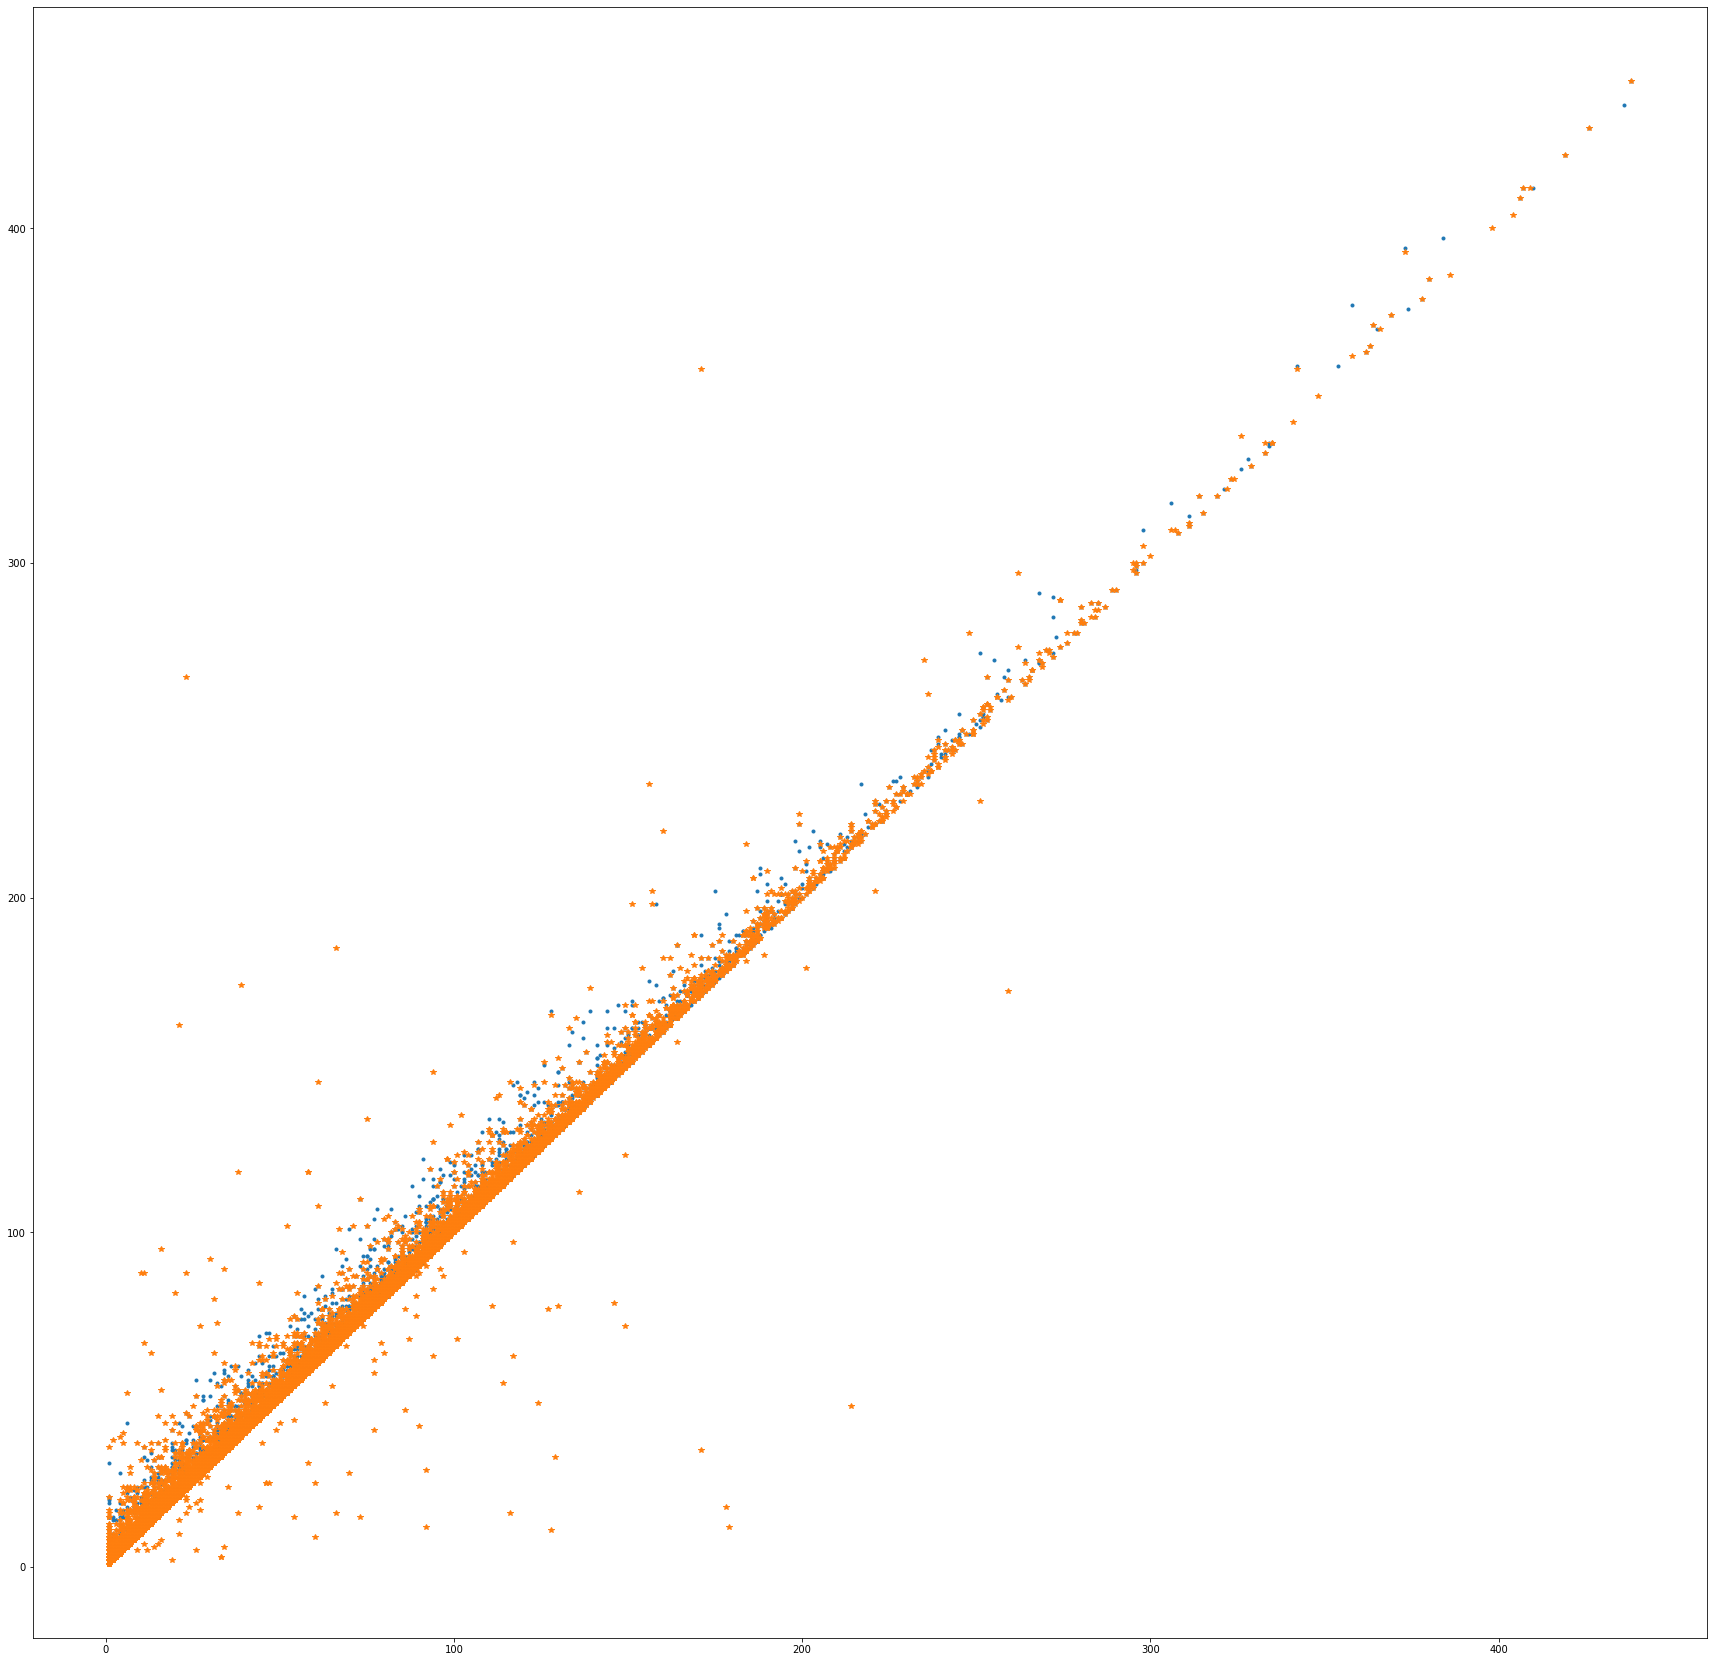

In [ ]:
import matplotlib.pyplot as plt

#predictions = model.predict(x_test)
sampled_start = np.argmax(predictions[0], axis=-1)
sampled_end = np.argmax(predictions[1], axis=-1)

plt.figure(figsize=(30,30))
plt.plot(y_test[0], y_test[1], ".")
plt.plot(sampled_start, sampled_end,"*")

In [ ]:
evaluation = !python3 evaluate.py test_set.json dev_predictions.txt
print(evaluation)
if ENABLE_WANDB:
    wandb.log({"Evaluate": wandb.Html("<pre>"+str(evaluation)+"<pre>", inject=False)})

['{', '  "exact": 83.94512771996216,', '  "f1": 90.59477453585146,', '  "total": 10570,', '  "HasAns_exact": 83.94512771996216,', '  "HasAns_f1": 90.59477453585146,', '  "HasAns_total": 10570', '}']


In [ ]:
# inference with custom context and question

def custom_inference(context, question):
    preprocessed_context = " ".join(str(context).split())
    preprocessed_question = " ".join(str(question).split())
    tokenized_context = tokenizer(preprocessed_context)
    tokenized_question = tokenizer(preprocessed_question)
    input_ids = tokenized_context["input_ids"] + tokenized_question["input_ids"][1:]
    token_type_ids = [0] * len(tokenized_context["input_ids"]) + [1] * len(tokenized_question["input_ids"][1:])
    attention_mask = [1] * len(input_ids)
    padding_length = max_seq_length - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([0] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
    else:
        print("Error! The input is too long")
    input_word_ids = np.array(input_ids)
    input_mask = np.array(attention_mask)
    input_type_ids = np.array(token_type_ids)
    x = [np.expand_dims(input_word_ids, axis =0), np.expand_dims(input_mask, axis = 0), 
         np.expand_dims(input_type_ids,axis=0)]
    predictions = model.predict(x)
    start, end = list(np.argmax(predictions, axis=-1).squeeze())
    predicted_ans = tokenizer.decode(tokenized_context["input_ids"][start : end+1])
    return predicted_ans

In [ ]:
context = "Thomas Cruise Mapother IV (born July 3, 1962) is an American actor and producer. He has received various accolades for his work, including three Golden Globe Awards and three nominations for Academy Awards. He is one of the highest-paid actors in the world. His films have grossed over $4 billion in North America and over $10.1 billion worldwide, making him one of the highest-grossing box office stars of all time. Cruise began acting in the early 1980s and made his breakthrough with leading roles in the comedy film Risky Business (1983) and action drama film Top Gun (1986). Critical acclaim came with his roles in the drama films The Color of Money (1986), Rain Man (1988), and Born on the Fourth of July (1989). For his portrayal of Ron Kovic in the latter, he won a Golden Globe Award and received a nomination for the Academy Award for Best Actor. As a leading Hollywood star in the 1990s, he starred in several commercially successful films, including the drama A Few Good Men (1992), the thriller The Firm (1993), the horror film Interview with the Vampire (1994), and the romance Jerry Maguire (1996). For his role in the latter, he won a Golden Globe Award for Best Actor and received his second Academy Award nomination."
question = "What was the first film Tom Cruise acted in?"


predicted_answer = custom_inference(context, question)
print(predicted_answer)